<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/Copia_de_4_Febrero_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

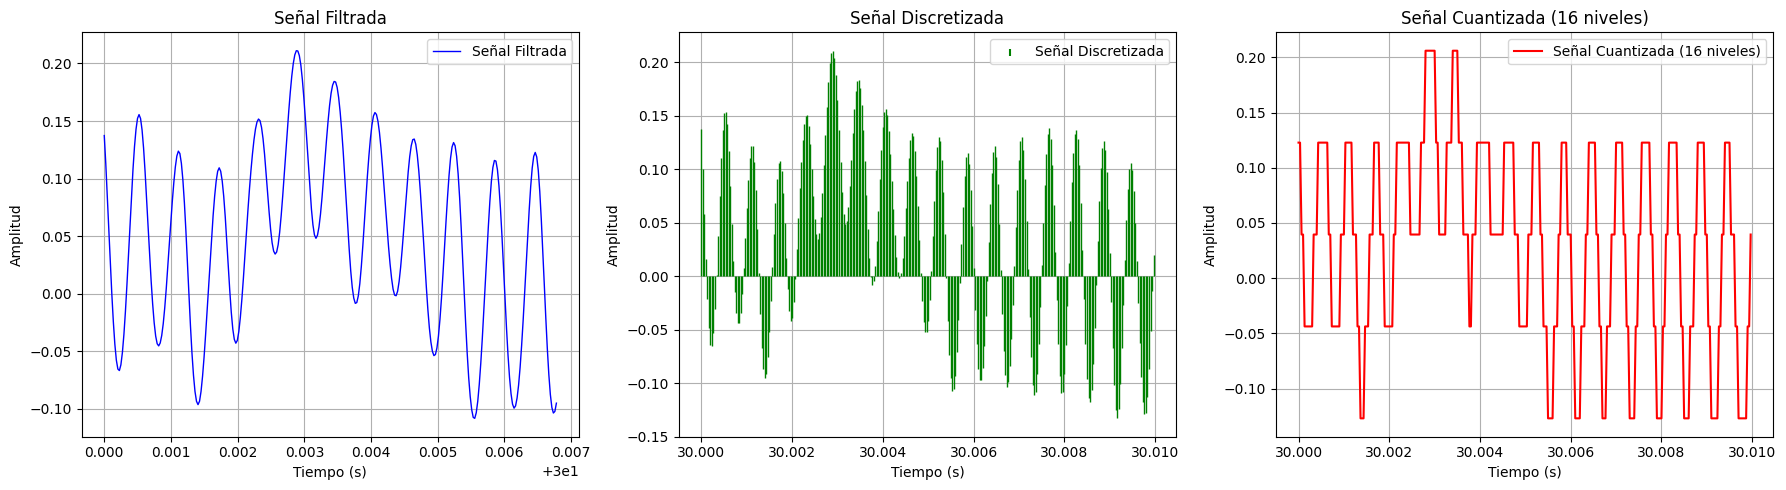

In [77]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.signal import butter, filtfilt

# Montar Google Drive
drive.mount('/content/drive')

# Configurar parámetros y ruta del audio
ruta_audio = "/content/drive/MyDrive/Audios/At-First-Sight-FiftySounds.wav"

# Leer el archivo de audio
audio_signal, sample_rate = sf.read(ruta_audio)

# Si el audio tiene más de un canal, se toma solo el primero
if audio_signal.ndim > 1:
    audio_signal = audio_signal[:, 0]

# Definir el segmento de audio correspondiente a los segundos 30-31
inicio_muestra = int(30 * sample_rate)
fin_muestra = int(31 * sample_rate)

# Definir filtro Butterworth de 4to orden pasa-banda entre 30 Hz y 15 kHz
low_cut_freq = 30.0     # 30 Hz
high_cut_freq = 15000.0 # 15 kHz
nyquist = sample_rate / 2.0
low_norm = low_cut_freq / nyquist
high_norm = high_cut_freq / nyquist
b, a = butter(N=4, Wn=[low_norm, high_norm], btype='band')

# Aplicar el filtro a toda la señal (filtfilt evita retraso de fase)
audio_signal_filtered = filtfilt(b, a, audio_signal)

# Extraer el segmento filtrado de los segundos 30 a 31
audio_segmento_filtrado = audio_signal_filtered[inicio_muestra:fin_muestra]
time_segmento = np.linspace(30, 31, num=len(audio_segmento_filtrado))

# Discretización de la señal filtrada a 30 kHz
sampling_rate_discrete = 30000       # Frecuencia de muestreo para la discretización (30 kHz)
sampling_period = 1 / sampling_rate_discrete
time_discrete = np.arange(30, 31, sampling_period)
audio_discrete = np.interp(time_discrete, time_segmento, audio_segmento_filtrado)

# Cuantización uniforme de la señal discretizada (16 niveles, 4 bits)
levels_uniforme = 16
q_min = np.min(audio_discrete)
q_max = np.max(audio_discrete)

def quantize_uniform(x, q_min, q_max, q_level):
    # Normaliza la señal al rango [0, q_level-1]
    x_normalize = (x - q_min) * (q_level - 1) / (q_max - q_min)
    x_normalize = np.clip(x_normalize, 0, q_level - 1)
    # Cuantiza y vuelve a escalar al rango original
    x_quant = np.round(x_normalize) * (q_max - q_min) / (q_level - 1) + q_min
    return x_quant

audio_cuantizada = quantize_uniform(audio_discrete, q_min, q_max, levels_uniforme)

# Número de muestras a mostrar (primeras 300 muestras)
num_muestras = 300

# Crear tres subgráficas en una misma fila
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Gráfica 1: Señal Filtrada (línea azul)
axs[0].plot(time_segmento[:num_muestras], audio_segmento_filtrado[:num_muestras],
            label="Señal Filtrada", color="blue", linewidth=1)
axs[0].set_title("Señal Filtrada")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Amplitud")
axs[0].grid(True)
axs[0].legend()

# Gráfica 2: Señal Discretizada (stem en verde: palitos)
markerline, stemlines, baseline = axs[1].stem(time_discrete[:num_muestras], audio_discrete[:num_muestras],
                                                linefmt="green", markerfmt=" ", basefmt=" ")
plt.setp(stemlines, 'linewidth', 1)  # ajustar grosor de las líneas
axs[1].set_title("Señal Discretizada")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Amplitud")
axs[1].grid(True)
axs[1].legend(["Señal Discretizada"])

# Gráfica 3: Señal Cuantizada (línea discontinua con marcadores cuadrados)
axs[2].plot(time_discrete[:num_muestras], audio_cuantizada[:num_muestras],
            label="Señal Cuantizada (16 niveles)", color="red", markersize=5, linewidth=1.5)
axs[2].set_title("Señal Cuantizada (16 niveles)")
axs[2].set_xlabel("Tiempo (s)")
axs[2].set_ylabel("Amplitud")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt


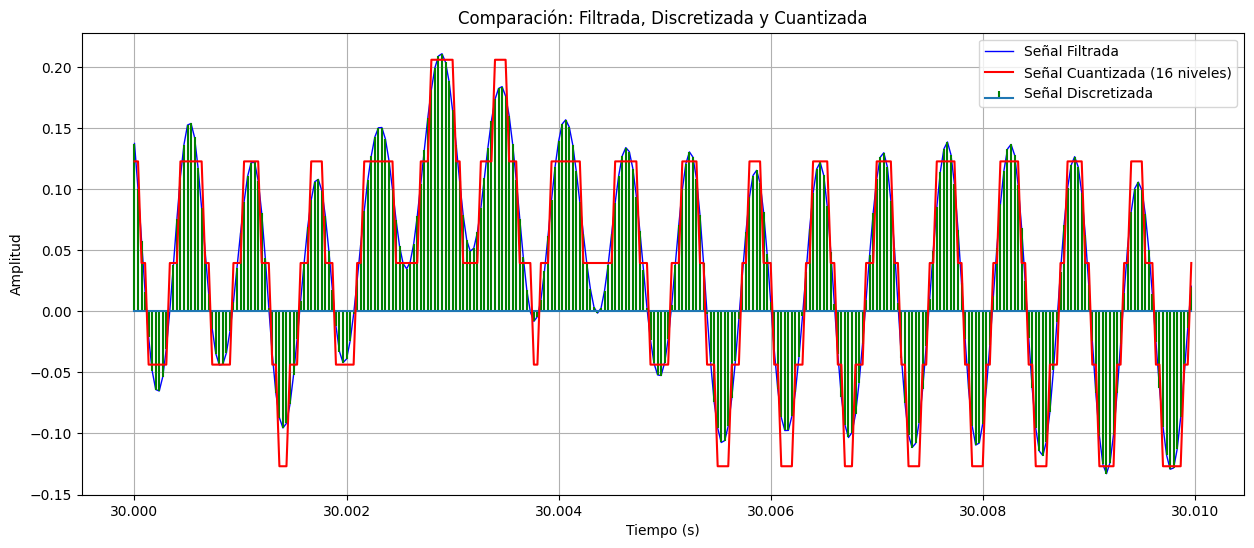

In [78]:
# Extender el tiempo del segmento filtrado al rango del tiempo discreto
# Se interpolará la señal filtrada para que coincida en longitud con la señal cuantizada
time_segmento_extendido = np.linspace(time_segmento[0], time_segmento[-1], len(time_discrete))
audio_segmento_filtrado_extendido = np.interp(time_segmento_extendido, time_segmento, audio_segmento_filtrado)

# Graficar todas las señales superpuestas
plt.figure(figsize=(15, 6))

# Señal Filtrada
plt.plot(time_segmento_extendido[:300], audio_segmento_filtrado_extendido[:300], label="Señal Filtrada", color="blue", linewidth=1)

# Señal Discretizada (usando stem)
plt.stem(time_discrete[:300], audio_discrete[:300], label="Señal Discretizada", linefmt="green", markerfmt="", basefmt="")

# Señal Cuantizada (línea continua interpolada)
plt.plot(time_discrete[:300], audio_cuantizada[:300], label="Señal Cuantizada (16 niveles)", color="red", linewidth=1.5)

# Configurar gráfico
plt.title("Comparación: Filtrada, Discretizada y Cuantizada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()


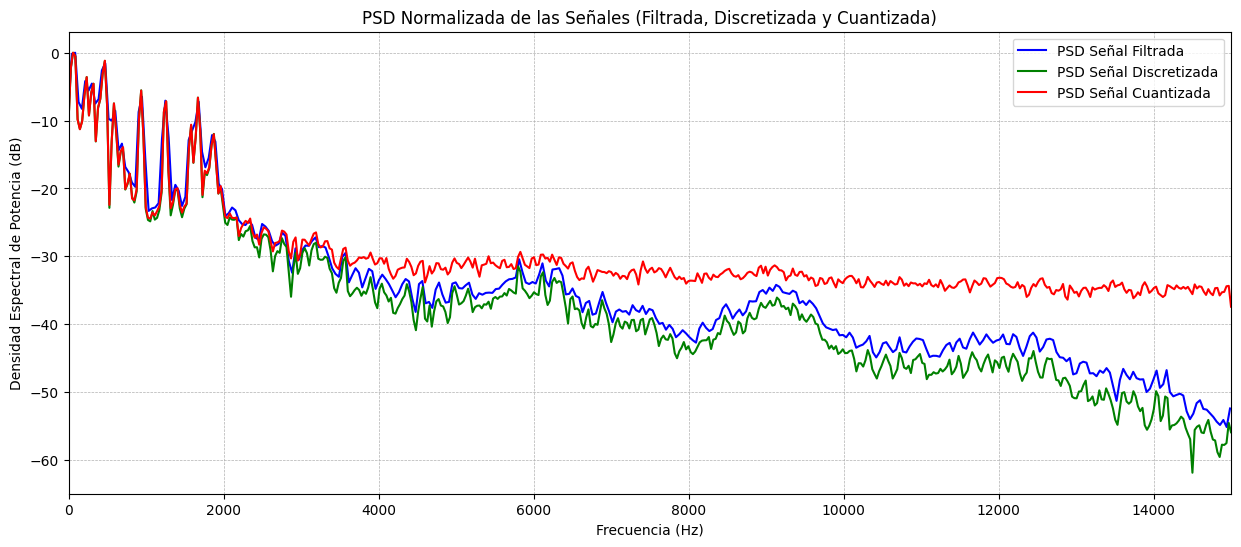

In [79]:
from scipy.signal import welch

# Calcular PSD para la señal discretizada
frequencies_discretizada, psd_discretizada = welch(audio_discrete, fs=sampling_rate_discrete, nperseg=1024)
psd_discretizada_normalizada = 10 * np.log10(psd_discretizada / np.max(psd_discretizada))  # Normalización a 0 dB

# Calcular PSD para la señal cuantizada
frequencies_cuantizada, psd_cuantizada = welch(audio_cuantizada, fs=sampling_rate_discrete, nperseg=1024)  # Using sampling_rate_discrete
psd_cuantizada_normalizada = 10 * np.log10(psd_cuantizada / np.max(psd_cuantizada))  # Normalización a 0 dB

# Calcular PSD para la señal filtrada (added this section)
frequencies_filtrada, psd_filtrada = welch(audio_segmento_filtrado, fs=sample_rate, nperseg=1024)
psd_filtrada_normalizada = 10 * np.log10(psd_filtrada / np.max(psd_filtrada))  # Normalización a 0 dB


# Limitar las frecuencias a 15 kHz
max_freq_index_filtrada = np.where(frequencies_filtrada <= 15000)[0][-1]
max_freq_index_discretizada = np.where(frequencies_discretizada <= 15000)[0][-1]
max_freq_index_cuantizada = np.where(frequencies_cuantizada <= 15000)[0][-1]

frequencies_filtrada = frequencies_filtrada[:max_freq_index_filtrada + 1]
psd_filtrada_normalizada = psd_filtrada_normalizada[:max_freq_index_filtrada + 1]

frequencies_discretizada = frequencies_discretizada[:max_freq_index_discretizada + 1]
psd_discretizada_normalizada = psd_discretizada_normalizada[:max_freq_index_discretizada + 1]

frequencies_cuantizada = frequencies_cuantizada[:max_freq_index_cuantizada + 1]
psd_cuantizada_normalizada = psd_cuantizada_normalizada[:max_freq_index_cuantizada + 1]

# Graficar las PSD normalizadas
plt.figure(figsize=(15, 6))
plt.plot(frequencies_filtrada, psd_filtrada_normalizada, label="PSD Señal Filtrada", color="blue", linewidth=1.5)
plt.plot(frequencies_discretizada, psd_discretizada_normalizada, label="PSD Señal Discretizada", color="green", linewidth=1.5)
plt.plot(frequencies_cuantizada, psd_cuantizada_normalizada, label="PSD Señal Cuantizada", color="red", linewidth=1.5)

# Configuración del gráfico
plt.title("PSD Normalizada de las Señales (Filtrada, Discretizada y Cuantizada)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad Espectral de Potencia (dB)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.xlim([0, 15000])  # Limitar el eje x a 15 kHz
plt.show()

In [80]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
def pulse_train(t, T, tau):
    """
    Genera un tren de pulsos rectangulares.

    Parámetros:
      t   : Array de tiempo.
      T   : Período de la señal.
      tau : Ancho del pulso.

    Retorna:
      Señal del tren de pulsos: 1 cuando (t % T) < tau, 0 en otro caso.
    """
    return np.where((t % T) < tau, 1, 0.0)

def plot_pulse_train_and_spectrum(tau):
    # Parámetros de la señal
    T = 1            # Período en segundos
    fs = 30000.0        # Frecuencia de muestreo en Hz (30 kHz)
    n_periods = 5       # Número de períodos a simular
    total_time = n_periods * T
    N_points = int(total_time * fs)  # Total de puntos en el vector de tiempo

    # Vector de tiempo (se usa endpoint=False para que la simulación sea consistente con la FFT)
    t = np.linspace(0, total_time, N_points, endpoint=False)
    signal = pulse_train(t, T, tau)

    # Cálculo de la FFT
    N = len(signal)
    dt = 1/fs                   # Intervalo de muestreo
    fft_signal = np.fft.fft(signal)
    freq = np.fft.fftfreq(N, dt)

    # Seleccionar solo las frecuencias positivas
    pos_mask = freq >= 0
    freq_pos = freq[pos_mask]
    fft_signal_pos = fft_signal[pos_mask]
    magnitude = np.abs(fft_signal_pos)

    # Convertir la magnitud a decibelios (dB) y evitar log(0) usando una pequeña constante eps
    eps = np.finfo(float).eps
    magnitude_db = 20 * np.log10(magnitude + eps)

    magnitude_db_norm = (magnitude_db - np.min(magnitude_db)) * (60 / (np.max(magnitude_db) - np.min(magnitude_db)))

    # Crear figura con dos subgráficas en una misma fila (1 fila, 2 columnas)
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Gráfica en el dominio del tiempo
    axs[0].plot(t, signal, drawstyle='steps-pre', linewidth=2)
    axs[0].set_xlabel("Tiempo (s)")
    axs[0].set_ylabel("Amplitud")
    axs[0].set_title(f"Tren de pulsos rectangulares: T = {T} s, τ = {tau} s")
    axs[0].grid(True)
    axs[0].set_ylim(-0.2, 1.2)

    # Gráfica del espectro de Fourier (solo frecuencias positivas) en escala de decibelios
    axs[1].plot(freq_pos, magnitude, linewidth=2)
    axs[1].set_xlabel("Frecuencia (Hz)")
    axs[1].set_ylabel("Magnitud (dB)")
    axs[1].set_title("Espectro de Fourier")
    axs[1].grid(True)
    # Limitar el eje x para observar mejor los principales armónicos (ajusta el límite según lo necesites)
    axs[1].set_xlim(0, 5)

    plt.tight_layout()
    plt.show()

# Crear el control deslizante para modificar τ (entre 0 y 1 s)
interact(plot_pulse_train_and_spectrum, tau=FloatSlider(min=0, max=1.0, step=0.01, value=0.2))

interactive(children=(FloatSlider(value=0.2, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_pulse_train_and_spectrum(tau)>

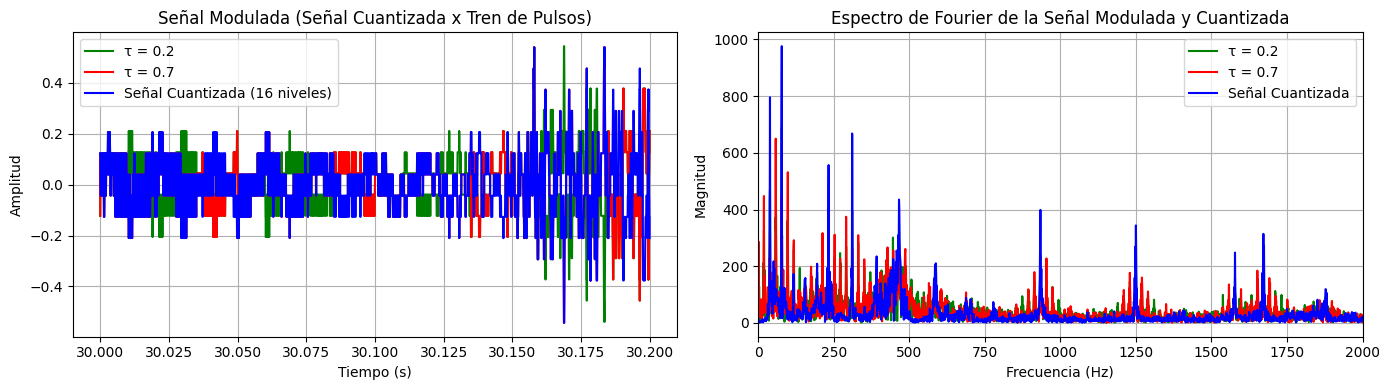

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from scipy.fft import fft, fftfreq

# Generar tren de pulsos rectangulares para tau = 0.2 y tau = 0.7
fp = 20  # Frecuencia del tren de pulsos (Hz)
tau_1 = 0.2  # Duty cycle 20%
tau_2 = 0.7  # Duty cycle 70%

tren_pulsos_1 = square(2 * np.pi * fp * time_discrete, duty=tau_1)
tren_pulsos_2 = square(2 * np.pi * fp * time_discrete, duty=tau_2)

# Multiplicar la señal cuantizada por los trenes de pulsos
señal_modulada_1 = audio_cuantizada * tren_pulsos_1
señal_modulada_2 = audio_cuantizada * tren_pulsos_2

# Aplicar Transformada de Fourier a las señales moduladas
N = len(señal_modulada_1)
fft_signal_1 = fft(señal_modulada_1)
fft_signal_2 = fft(señal_modulada_2)
freq = fftfreq(N, d=1/sampling_rate_discrete)

# Filtrar solo las frecuencias positivas
pos_mask = freq >= 0
freq_pos = freq[pos_mask]
fft_signal_pos_1 = np.abs(fft_signal_1[pos_mask])
fft_signal_pos_2 = np.abs(fft_signal_2[pos_mask])

# Aplicar la Transformada de Fourier a la señal cuantizada
spectrum_cuantizada = fft(audio_cuantizada)
frequencies_cuantizada = fftfreq(N, d=1/sampling_rate_discrete)

# Obtener solo las frecuencias positivas de la señal cuantizada
pos_mask_cuantizada = frequencies_cuantizada >= 0
freq_cuantizada = frequencies_cuantizada[pos_mask_cuantizada]
spectrum_cuantizada_pos = np.abs(spectrum_cuantizada[pos_mask_cuantizada])

# Crear figura con dos gráficas en una fila
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Señal Modulada en el dominio del tiempo con la señal cuantizada superpuesta
axs[0].plot(time_discrete[:6000], señal_modulada_1[:6000], color='g', label=f"τ = {tau_1}")
axs[0].plot(time_discrete[:6000], señal_modulada_2[:6000], color='r', label=f"τ = {tau_2}")
axs[0].plot(time_discrete[:6000], audio_cuantizada[:6000], label="Señal Cuantizada (16 niveles)", color="blue", linewidth=1.5)
axs[0].set_title("Señal Modulada (Señal Cuantizada x Tren de Pulsos)")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Amplitud")
axs[0].legend()
axs[0].grid()


# Espectro de Fourier con la señal cuantizada incluida
axs[1].plot(freq_pos, fft_signal_pos_1, color='green', label=f"τ = {tau_1}")
axs[1].plot(freq_pos, fft_signal_pos_2, color='red', label=f"τ = {tau_2}")
axs[1].plot(freq_cuantizada, spectrum_cuantizada_pos, color='blue', linewidth=1.5, label="Señal Cuantizada")
axs[1].set_title("Espectro de Fourier de la Señal Modulada y Cuantizada")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[1].set_ylabel("Magnitud")
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(0, 2000)  # Limitar el eje x para mejor visualización

plt.tight_layout()
plt.show()


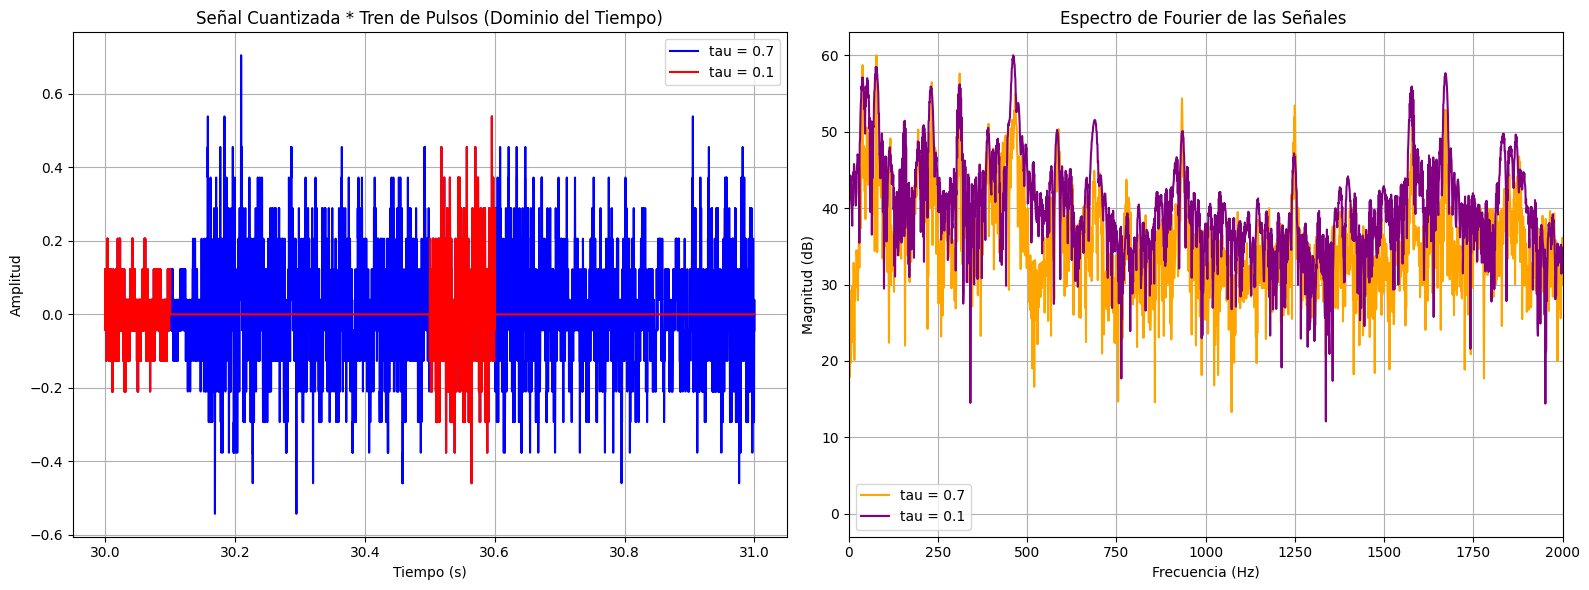

In [83]:
# ------------------------- #
# Parámetros y variables
# ------------------------- #
T = 0.5  # Período del tren de pulsos (1 s)
eps = np.finfo(float).eps  # Pequeño valor para evitar log(0)

# Se asume que las siguientes variables y funciones ya están definidas:
# - time_discrete: vector de tiempo discreto
# - audio_cuantizada: señal cuantizada en el intervalo deseado
# - fs_discrete: frecuencia de muestreo
# - pulse_train: función que genera un tren de pulsos dado un vector de tiempo, período T y ancho tau
# Ejemplo de definición de pulse_train (si no la tienes definida):
# def pulse_train(t, T, tau):
#     return ((t % T) < tau).astype(float)

# Ajuste del vector de tiempo para el tren de pulsos
t_pulse = time_discrete - 30  # Se ajusta para que el tren de pulsos esté definido en [0, 1] s
fs_discrete = 30000
# ------------------------- #
# Generación de señales moduladas
# ------------------------- #

# Señal 1: tau = 0.7
tau1 = 0.7
pulse_signal1 = pulse_train(t_pulse, T, tau1)
signal_modulated1 = audio_cuantizada * pulse_signal1

# Señal 2: tau = 0.2
tau2 = 0.1
pulse_signal2 = pulse_train(t_pulse, T, tau2)
signal_modulated2 = audio_cuantizada * pulse_signal2

# ------------------------- #
# Cálculo de la FFT para ambas señales
# ------------------------- #
N = len(signal_modulated1)  # Se asume que ambas señales tienen la misma longitud
dt = 1 / fs_discrete

# FFT para la señal con tau1
fft_modulated1 = np.fft.fft(signal_modulated1)
freq = np.fft.fftfreq(N, dt)
pos_mask = freq >= 0
freq_pos = freq[pos_mask]
fft_modulated1_pos = fft_modulated1[pos_mask]
magnitude1 = np.abs(fft_modulated1_pos)


# FFT para la señal con tau2
fft_modulated2 = np.fft.fft(signal_modulated2)
fft_modulated2_pos = fft_modulated2[pos_mask]
magnitude2 = np.abs(fft_modulated2_pos)



# Conversión a decibelios
magnitude1_db = 20 * np.log10(magnitude1 + eps)
magnitude2_db = 20 * np.log10(magnitude2 + eps)

# Normalización de cada espectro entre 0 y 60 dB
magnitude1_min = magnitude1_db.min()
magnitude1_max = magnitude1_db.max()
magnitude1_norm = 60 * (magnitude1_db - magnitude1_min) / (magnitude1_max - magnitude1_min)

magnitude2_min = magnitude2_db.min()
magnitude2_max = magnitude2_db.max()
magnitude2_norm = 60 * (magnitude2_db - magnitude2_min) / (magnitude2_max - magnitude2_min)

# ------------------------- #
# Gráfica: Señales en el dominio del tiempo y espectros superpuestos
# ------------------------- #

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# (I) Gráfica en el dominio del tiempo (se muestran las primeras 300 muestras)
num_muestras = 30000
axs[0].plot(time_discrete[:num_muestras], signal_modulated1[:num_muestras],
            label=f'tau = {tau1}', color='blue', linewidth=1.5)
axs[0].plot(time_discrete[:num_muestras], signal_modulated2[:num_muestras],
            label=f'tau = {tau2}', color='red', linewidth=1.5)
axs[0].set_title("Señal Cuantizada * Tren de Pulsos (Dominio del Tiempo)")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Amplitud")
axs[0].grid(True)
axs[0].legend()

# (II) Gráfica de los espectros de Fourier (en decibelios)
axs[1].plot(freq_pos, magnitude1_norm, label=f'tau = {tau1}', color='orange', linewidth=1.5)
axs[1].plot(freq_pos, magnitude2_norm, label=f'tau = {tau2}', color='purple', linewidth=1.5)
axs[1].set_title("Espectro de Fourier de las Señales ")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[1].set_ylabel("Magnitud (dB)")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlim(0, 2000)  # Limita el eje x para una mejor visualización de los armónicos

plt.tight_layout()
plt.show()